In [3]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
df.shape

(113842, 31)

In [4]:
df.isnull().sum()

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

In [5]:
val_df = pd.read_csv('./data/val.csv')
val_df['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

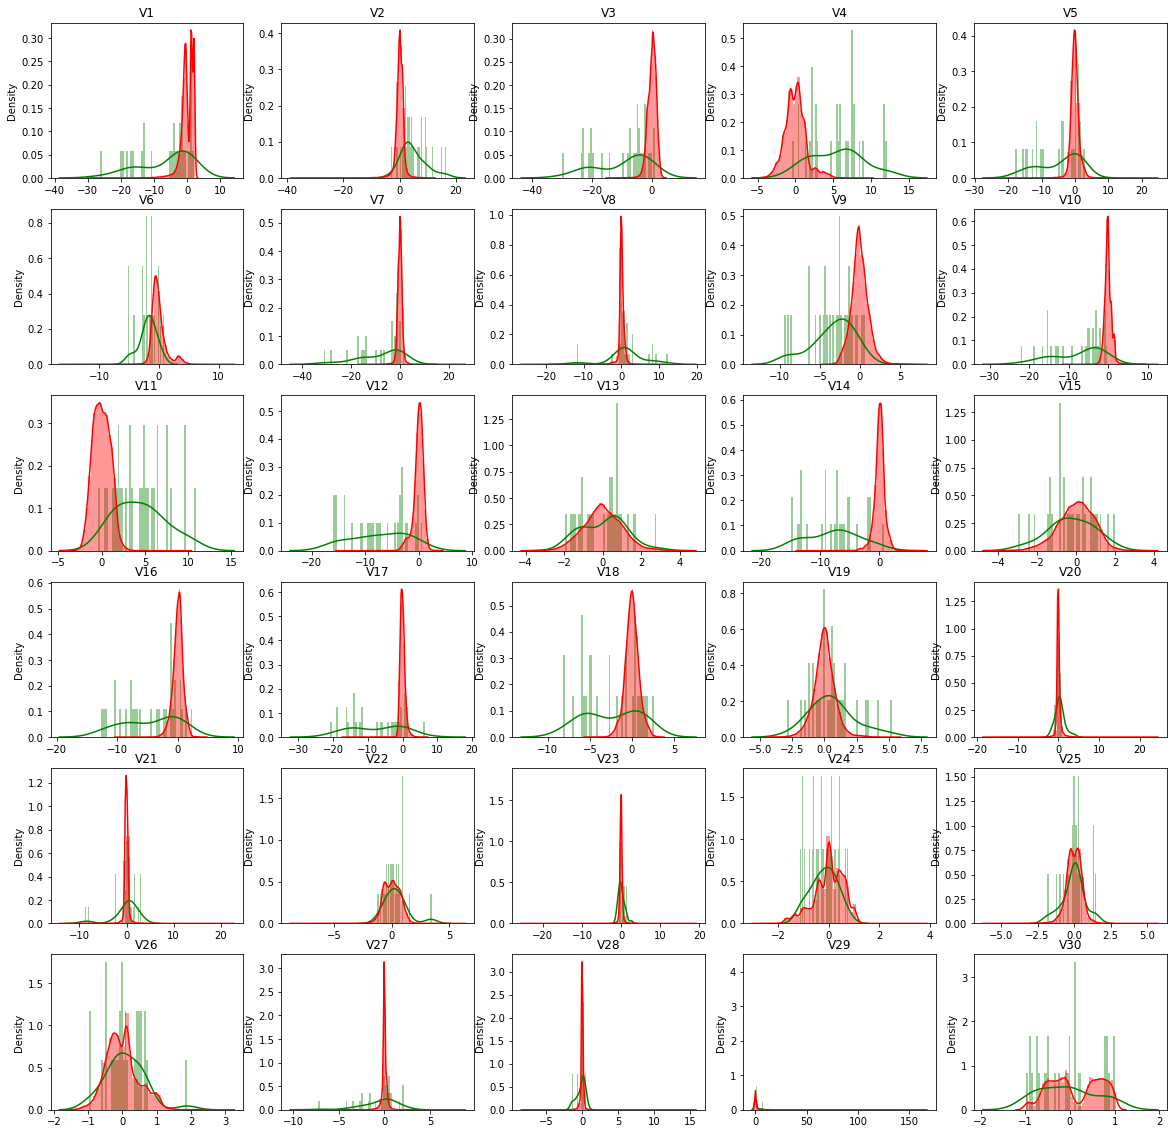

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

columns = val_df.drop(['ID','Class'], axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(val_df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(val_df[val_df.Class==1][col], bins = 50, color='g')
    sns.distplot(val_df[val_df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

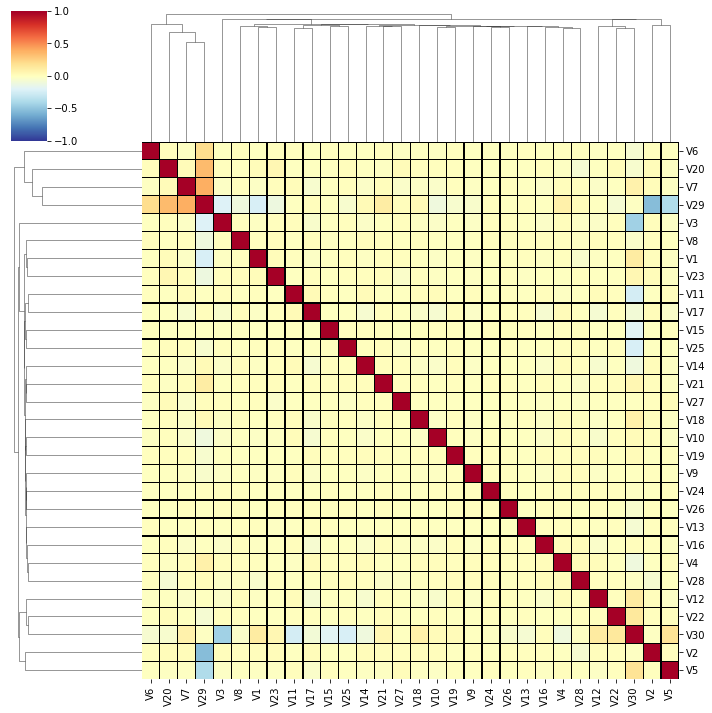

In [7]:
import seaborn as sns


sns.clustermap(df.corr().drop('ID',axis=1)[1:], 
               cmap = 'RdYlBu_r',
               vmin = -1, vmax = 1,
               linewidth=0.3,
               linecolor='black'
              )

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

printcipalComponents = pca.fit_transform(val_df.drop(['ID','Class'],axis=1))

principalDf = pd.DataFrame(data=printcipalComponents, columns = ['1', '2', '3'])

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.31596124 0.09027289 0.05780074]
0.46403486854004794


In [9]:
principalDf

,1,2,3
0,-1.415211,0.768797,-0.720164
1,-0.888411,-0.767768,-0.021114
2,-0.938269,-0.926827,-0.186606
3,-0.611262,-0.836303,-0.718152
4,-1.486417,3.619941,-0.583235
...,...,...,...
28457,-0.890241,0.852614,0.958966
28458,-0.132278,0.836097,1.190936
28459,-0.533528,0.639967,0.757984
28460,-1.319773,-2.047684,1.123123


In [10]:
x,y,z = principalDf['1'],principalDf['2'],principalDf['3']

In [11]:
color_ls = val_df['Class'].apply(lambda x : 'blue' if x == 0 else 'red')

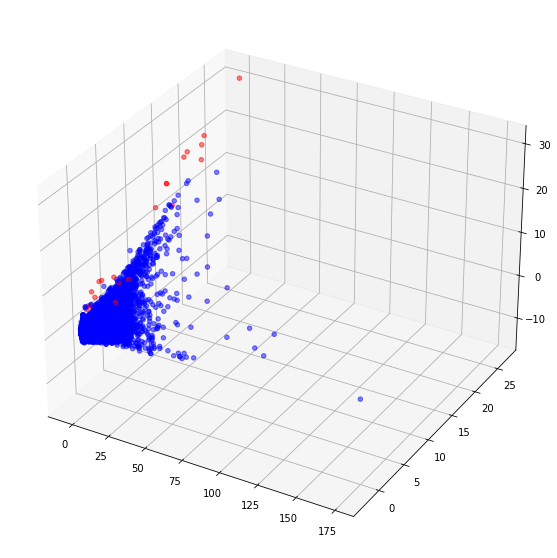

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.scatter(x,y,z,alpha=0.5,color=color_ls)

# model

In [13]:

import numpy as np
data = val_df.drop('ID',axis=1).copy()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xcopy, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

In [14]:
data.shape

(28462, 31)

In [15]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

In [16]:
# val_contamination = val_contamination-0.0005
val_contamination

0.0010551491277433877

In [17]:
# from sklearn.preprocessing import StandardScaler
# import numpy as np


# data = val_df.drop('ID',axis=1).copy()
# normal_data = data.loc[data["Class"] == 0]
# fraud_data = data.loc[data["Class"] == 1]

# all_cols = list(data)[:] 
# pca_columns = list(data)[:-1] # all cols without Class

# # CREATE the TRAIN and TEST sets
# # Fraud data is ONLY in TEST - not in TRAIN

# normal_pca_data = normal_data[pca_columns]
# fraud_pca_data = fraud_data[pca_columns]

# num_test = 28462
# shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
# X_train = shuffled_data

# X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
# y_test = np.concatenate([np.zeros(num_test), np.ones(492)])


# X_inliers = shuffled_data[-num_test:]
# X_outliers = fraud_pca_data[:]
# X = np.r_[X_inliers, X_outliers]

# n_outliers = len(X_outliers)
# ground_truth = np.ones(len(X), dtype=int)
# ground_truth[-n_outliers:] = -1

# PercFraud = n_outliers / X_test.shape[0]
# PercFraud

# print('X_inliers ', X_inliers.shape)
# print('X_outliers ', X_outliers.shape)
# print('X ', X.shape)
# print('n_outliers ', n_outliers)
# print('percent fraud in test: ', PercFraud)

In [18]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(support_fraction = 1,assume_centered=False, contamination = val_contamination,random_state=777)
y_pred = cov.fit_predict(val_df.drop('ID',axis=1))

In [19]:
val_df['predict']=y_pred
val_df['predict'] = val_df['predict'].apply(lambda x : 0 if x==1 else 1)

In [20]:
from sklearn.metrics import f1_score
f1_score(val_df['Class'],val_df['predict'],average='macro')

0.9097393418694286

In [21]:
val_df['predict'].value_counts()

0    28431
1       31
Name: predict, dtype: int64

In [22]:
val_df['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

# test

In [23]:
import pandas as pd

test_df = pd.read_csv('./data/test.csv')
test_df.shape

(142503, 31)

In [24]:
test_x = test_df.drop(columns=['ID'])
cov = EllipticEnvelope(support_fraction = 1,assume_centered=False, contamination = val_contamination,random_state=77)
test_pred = cov.fit_predict(test_x) # model prediction

In [25]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [26]:
submit['Class'] = test_pred
submit['Class'] = submit['Class'].apply(lambda x : 0 if x==1 else 1)
submit.to_csv('./submit.csv', index=False)

In [27]:
submit['Class'].value_counts()

0    142352
1       151
Name: Class, dtype: int64